In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import networkx as nx

In [ ]:
def show_image(img, title="Image", cmap_type=None):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb, cmap=cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [ ]:
def saliency_detection():
    image = cv2.imread("sample.jpg")
    saliency = cv2.saliency.StaticSaliencySpectralResidual_create()
    (success, saliencyMap) = saliency.computeSaliency(image)
    saliencyMap = (saliencyMap * 255).astype("uint8")

    show_image(image, "Original Image")
    plt.imshow(saliencyMap, cmap='gray')
    plt.title("Saliency Map")
    plt.axis('off')
    plt.show()

In [ ]:
def kmeans_segmentation():
    image = cv2.imread("sample.jpg")
    Z = image.reshape((-1, 3))
    Z = np.float32(Z)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, label, center = cv2.kmeans(Z, 4, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    center = np.uint8(center)
    res = center[label.flatten()]
    segmented_image = res.reshape((image.shape))

    show_image(image, "Original Image")
    show_image(segmented_image, "Segmented Image (KMeans)")

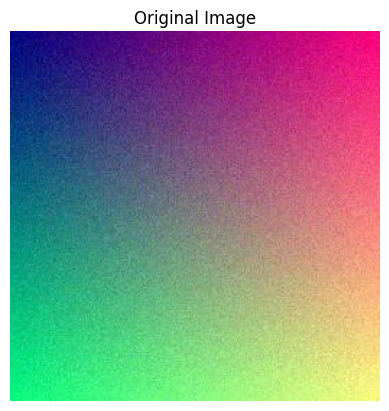

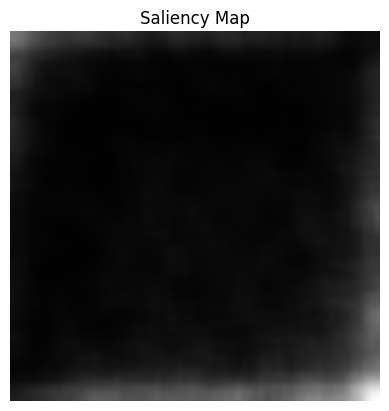

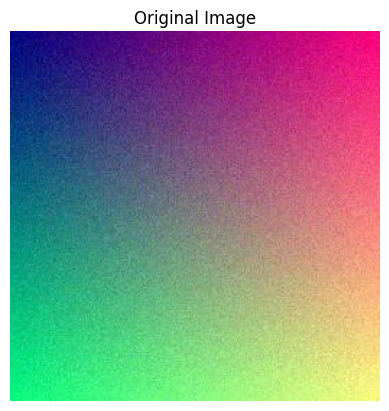

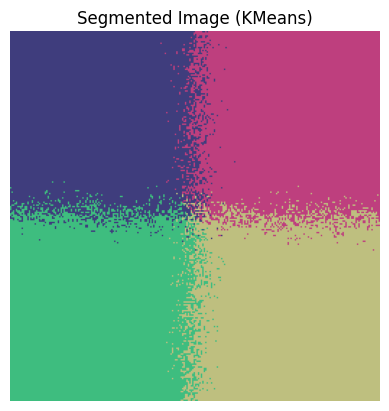

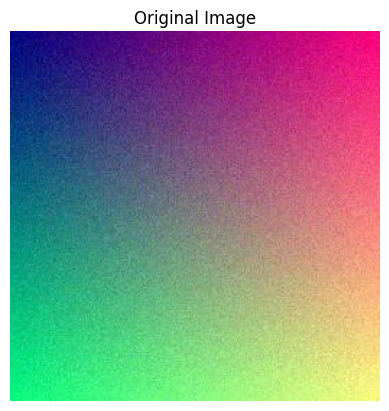

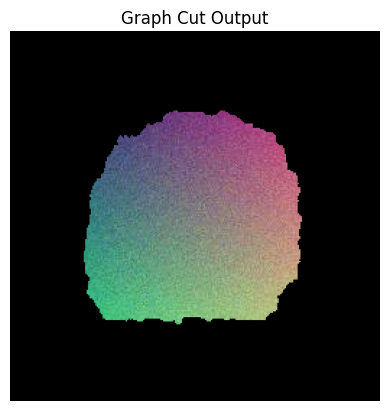

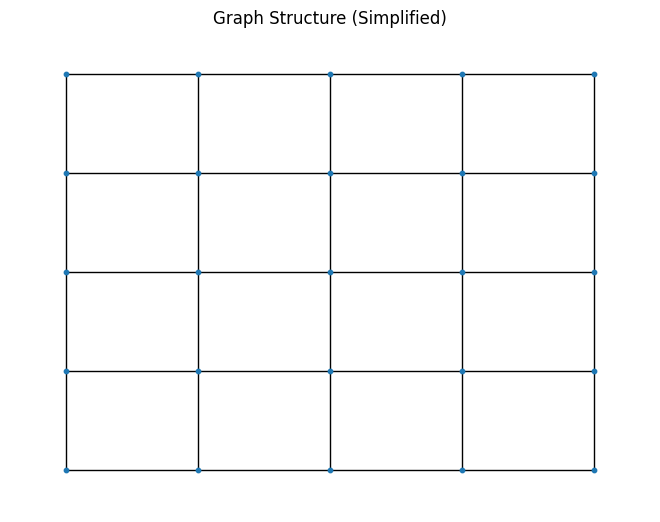

In [ ]:
def graph_cut_segmentation():
    image = cv2.imread("sample.jpg")
    mask = np.zeros(image.shape[:2], np.uint8)

    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)

    rect = (50, 50, image.shape[1]-100, image.shape[0]-100)
    cv2.grabCut(image, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    mask2 = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
    output = image * mask2[:, :, np.newaxis]

    show_image(image, "Original Image")
    show_image(output, "Graph Cut Output")

    G = nx.grid_2d_graph(image.shape[0]//50, image.shape[1]//50)
    pos = dict((n, n) for n in G.nodes())
    nx.draw(G, pos=pos, node_size=10, with_labels=False)
    plt.title('Graph Structure (Simplified)')
    plt.show()

if __name__ == "__main__":
    saliency_detection()
    kmeans_segmentation()
    graph_cut_segmentation()

task 2

In [ ]:
import torch
import torch.nn as nn
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nz = 100     # latent vector size
ngf = 64     # generator feature maps
nc = 3       # number of color channels (RGB)
frame_size = 64  # frame resolution 64x64

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
netG = Generator().to(device)

In [ ]:
fixed_noise = torch.randn(16, nz, 1, 1, device=device)

In [ ]:
fake_frames = netG(fixed_noise).detach().cpu()

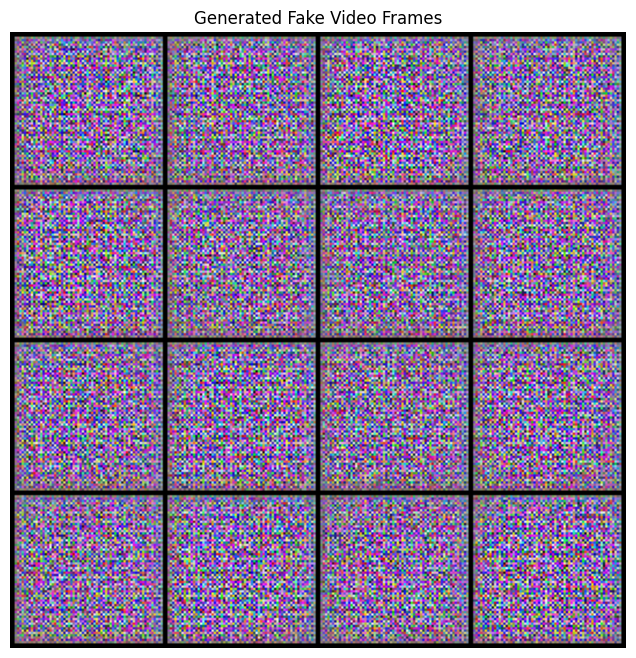

In [ ]:
grid = vutils.make_grid(fake_frames, nrow=4, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0))
plt.title("Generated Fake Video Frames")
plt.axis('off')
plt.show()